In [1]:
import netCDF4
import numpy as np
import pandas
import glob
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from scipy.stats import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from get_LWPCMIP5data import *
from get_LWPCMIP6data import *
from get_OBSLRMdata import *
from useful_func_cy import *
from fitLRM_cy1 import *
from fitLRM_cy2 import *

from fitLRMobs import *
from useful_func_cy import *
from calc_Radiation_LRM_1 import *
from calc_Radiation_LRM_2 import *
from calc_Radiation_OBS_2 import *

from area_mean import *
from binned_cyFunctions5 import *
from useful_func_cy import *

In [2]:
# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set area-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

path1 = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path6 = '/glade/scratch/chuyan/Plots/CMIP_R_lwp_3/'
path_plot = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/plot_file/Explore_1/'

In [3]:
# Model list (Global Climate Model);
exp = 'piControl'

# CMIP6: 31 (30: BCCCSMCM2MR)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
# BCCCSMCM2MR = {'modn': 'BCC-CSM2-MR', 'consort': 'BCC', 'cmip': 'cmip6',
#                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}

FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
# HADGEM3 = {'modn': 'HadGEM3-GC31-LL', 'consort': 'MOHC', 'cmip': 'cmip6',
#             'exper': 'piControl', 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}   #..missing 'wap' in 'piControl' exp(Daniel says that HadGEM3-GC31 not using p-level, so doesn't have variables on p-level
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: 22 (20, ACCESS10, ACCESS13)
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

MIROCESM = {'modn': 'MIROC-ESM', 'consort': 'MIROC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MRICGCM3 = {'modn': 'MRI-CGCM3', 'consort': 'MRI', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMLR = {'modn': 'MPI-ESM-LR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
bcccsm11 = {'modn': 'bcc-csm1-1', 'consort': 'BCC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2G = {'modn': 'GFDL-ESM2G', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2M = {'modn': 'GFDL-ESM2M', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}


In [4]:
deck2 = [CanESM5, E3SM10, CESM2FV2, CESM2, CNRMCM61, CESM2WACCMFV2, CNRMESM21, NESM3, IPSLCM6ALR, CESM2WACCM, MIROCESM, TaiESM1, ECEarth3Veg, CNRMCM61HR, ECEarth3, 
         FGOALSs2, IPSLCM5ALR, CSIRO_Mk360, BNUESM, GFDLCM3, GFDLCM4, SAM0, CanESM2, MPIESMLR, CMCCCM2SR5, MPIESMMR, FGOALSg2, BCCESM1, CNRMCM5, AWICM11MR, MRIESM20, 
          GISSE21H, MPIESM12LR, CCSM4, NorESM1M, FGOALSg3, bcccsm11, MIROC5, GISSE21G, MIROCES2L, MRICGCM3, MIROC6, NorESM2MM, GFDLESM2M, GFDLESM2G, GISSE22G, GISSE21H, CAMSCSM1, GISSE2R, INM_CM48]

deck_nas2 = ['CanESM5', 'E3SM10', 'CESM2FV2', 'CESM2', 'CNRMCM61', 'CESM2WACCMFV2', 'CNRMESM21', 'NESM3', 'IPSLCM6ALR', 'CESM2WACCM', 'MIROCESM', 'TaiESM1', 'ECEarth3Veg', 'CNRMCM61HR', 'ECEarth3', 
         'FGOALSs2', 'IPSLCM5ALR', 'CSIRO_Mk360', 'BNUESM', 'GFDLCM3', 'GFDLCM4', 'SAM0', 'CanESM2', 'MPIESMLR', 'CMCCCM2SR5', 'MPIESMMR', 'FGOALSg2', 'BCCESM1', 'CNRMCM5', 'AWICM11MR', 'MRIESM20', 
          'GISSE21H', 'MPIESM12LR', 'CCSM4', 'NorESM1M', 'FGOALSg3', 'bcccsm11', 'MIROC5', 'GISSE21G', 'MIROCES2L', 'MRICGCM3', 'MIROC6', 'NorESM2MM', 'GFDLESM2M', 'GFDLESM2G', 'GISSE22G', 'GISSE21H', 'CAMSCSM1', 'GISSE2R', 'INM_CM48']

In [5]:
def radiative_transfer_model_test(data_dict, threshold_list, label = 'piControl'):
    # ---------------
    # 'data_dict' is the dictionary store the variables for calc radiative tranfer model (lwp, albedo, albedo_cs, ..)
    # 'threshold_list' is a list of the threshold values of 'albedo_cs': for filtering out the points with albedo_cs >= Threshold ;
    ## now calc two different radiative transfer models: 
    # M1. albedo = a1 * lwp + a2 * albedo_cs + a3;
    # M2. alpha_cre = albedo - albedo_cs = a1 * lwp + a2
    # ---------------

    coef_dict_Albedo = {}
    coef_dict_Alpha_cre = {}
    # Loop through filter threshold:
    for a in range(len(threshold_list)):

        TR_albedo_cs = threshold_list[a]

        # copy data from dictionary:

        x = deepcopy(data_dict['LWP'])

        y2 = deepcopy(data_dict['alpha_cre'])

        y1 = deepcopy(data_dict['albedo'])

        ck_a = deepcopy(data_dict['albedo_cs'])

        rsdt = deepcopy(data_dict['rsdt'])
        # conditions:
        rsdt[rsdt < 10.0] = np.nan
        ck_a[ck_a < 0] = np.nan
        ck_a[ck_a >= TR_albedo_cs] = np.nan

        # rsdt[rsdt < 10.0] = np.nan
        # ck_a[ck_a < 0] = np.nan
        # x[x >= np.nanpercentile(x, 95)] = np.nan
        print("threshold = ", TR_albedo_cs)

        # Processing 'nan' in aggregated data:
        Z_PI = (rsdt * ck_a * x * y2 * y1) * 1.
        ind_false = np.isnan(Z_PI)
        ind_true = np.logical_not(ind_false)

        print(" fration of not NaN points to All points" + " in "+label+ ": " + 
             str(np.asarray(np.nonzero(ind_true == True)).shape[1]/ len(ind_true.flatten())))

        # data_frame used for statsmodel:
        data = pandas.DataFrame({'x': x[ind_true].flatten(), 'y2': y2[ind_true].flatten(), 'y1': y1[ind_true].flatten(), 'ck_a': ck_a[ind_true].flatten()})

        # Fit the model
        model1 = ols("y2 ~ x", data).fit()
        model2 = ols("y1 ~ x + ck_a", data).fit()
        # print the summary
        print(" ")
        print("model1, alpha_cre = a1 * lwp + a2: ", ' ', model1.summary())
        print(" ")
        print("model2, albedo = a1* lwp + a2 * albedo_cs + a3: ", ' ', model2.summary())

        coef_array_alpha_cre = np.asarray([model1._results.params[1], model1._results.params[0]])
        coef_array_albedo = np.asarray([model2._results.params[1], model2._results.params[2], model2._results.params[0]])


        coef_dict_Albedo[str(threshold_list[a] *100.)] = coef_array_albedo
        coef_dict_Alpha_cre[str(threshold_list[a] *100.)] = coef_array_alpha_cre

    return coef_dict_Albedo, coef_dict_Alpha_cre


In [179]:
# Read two Regimes (Warm, Cold) data:

output_ARRAY = {}   # storage output file
output_intermedia = {}   # storage the 'rawdata_dict'

output_dict0_PI = {}
output_dict0_abr = {}

output_GMT = {}
output_2lrm_predict = {}  # dict, store annual, area_meaned prediction of LWP
output_2lrm_report = {}  # dict, store annual, area_meaned actual values of GCMs LWP
output_2lrm_coef_LWP = {}
output_2lrm_dict_Albedo = {}  # Coefficients of 2 regimes's albedo trained by report 'LWP' data
# output_2lrm_coef_albedo_lL = {}

# Raw data
output_2lrm_yr_bin_abr = {}
output_2lrm_yr_bin_PI = {}
output_2lrm_mon_bin_abr = {}
output_2lrm_mon_bin_PI = {}

# Metric raw data in specific units:
shape_mon_pi = {}
shape_mon_abr = {}
output_2lrm_metric_actual_PI = {}
output_2lrm_metric_actual_abr = {}

# Statistic metrics of PI:
output_Mean_training = {}
output_Stdev_training = {}

# Predict metric data in specific units:
output_2lrm_mon_bin_LWPpredi_PI = {}
output_2lrm_mon_bin_LWPpredi_abr = {}

# Index for regime(s): Only for 2lrm
output_ind_Cold_PI = {}
output_ind_Warm_PI = {}
output_ind_Cold_abr = {}
output_ind_Warm_abr = {}

Tr_sst =  0.0

for i in range(len(deck2)):
    # print("i", i)
    
    # folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '_r2r1_warmcold(Jan)_(largestpiR2)_Dec4th_Anomalies_Rtest' + '*' + '_dats.npz')
    folder_2lrm = glob.glob(path1+deck2[i]['modn'] + '__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest'+ '*' + '_dats.npz')
    
    print(len(folder_2lrm))
    
    if len(folder_2lrm) == 4:
        if (len(folder_2lrm[0]) < len(folder_2lrm[1])) & (len(folder_2lrm[0]) < len(folder_2lrm[2])) & (len(folder_2lrm[0]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[0]
        elif (len(folder_2lrm[1]) < len(folder_2lrm[0])) & (len(folder_2lrm[1]) < len(folder_2lrm[2])) & (len(folder_2lrm[1]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[2]) < len(folder_2lrm[0])) & (len(folder_2lrm[2]) < len(folder_2lrm[1])) & (len(folder_2lrm[2]) < len(folder_2lrm[3])):
            folder_best2lrm = folder_2lrm[2]
        else:
            folder_best2lrm = folder_2lrm[3]
        print(folder_best2lrm)
        # output_ARRAY[deck_nas2[i]] = load(folder_best2lrm, allow_pickle = True)  #+'_'+str(Tr_sst)
    
    elif len(folder_2lrm) == 3:
        if (len(folder_2lrm[1]) <  len(folder_2lrm[0])) & (len(folder_2lrm[1]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[1]
        elif (len(folder_2lrm[0]) <  len(folder_2lrm[1])) & (len(folder_2lrm[0]) <  len(folder_2lrm[2])):
            folder_best2lrm = folder_2lrm[0]
        else:
            folder_best2lrm = folder_2lrm[2]
        print(folder_best2lrm)
        # output_ARRAY[deck_nas2[i]] = load(folder_best2lrm, allow_pickle = True)  #+'_'+str(Tr_sst)
        
    elif len(folder_2lrm) == 2:
        if len(folder_2lrm[1]) <  len(folder_2lrm[0]):
            folder_best2lrm = folder_2lrm[1]
        else:
            folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
        # output_ARRAY[deck_nas2[i]] = load(folder_best2lrm, allow_pickle = True)  #+'_'+str(Tr_sst)
        
    else:
        
        folder_best2lrm = folder_2lrm[0]
        print(folder_best2lrm)
    
    output_ARRAY[deck_nas2[i]] = load(folder_best2lrm, allow_pickle=True)  #+'_'+str(Tr_sst)
    
    
    output_intermedia[deck_nas2[i]] = output_ARRAY[deck_nas2[i]]['rawdata_dict']
    
    output_GMT[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['GMT']
    output_2lrm_predict[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['predicted_metrics']
    output_2lrm_report[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['report_metrics']

    output_dict0_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_PI_var']
    output_dict0_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['dict1_abr_var']
    
    output_2lrm_coef_LWP[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Coef_dict']
    # print(output_2lrm_dict_Albedo, "i", i, output_intermedia[deck_nas2[i]][()].keys())
    output_2lrm_dict_Albedo[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['coef_dict_Albedo_pi']
    
    # Monthly data
    output_2lrm_mon_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_mon_bin_PI']
    output_2lrm_mon_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_mon_bin_abr']
    # Annually data
    output_2lrm_yr_bin_PI[deck_nas2[i]] = output_dict0_PI[deck_nas2[i]]['dict1_yr_bin_PI']
    output_2lrm_yr_bin_abr[deck_nas2[i]] = output_dict0_abr[deck_nas2[i]]['dict1_yr_bin_abr']
    
    # Flattened Metric monthly mean bin data
    shape_mon_pi[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_PI_3']
    shape_mon_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['shape_mon_abr_3']
    output_2lrm_metric_actual_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_training']
    output_2lrm_metric_actual_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['metric_predict']
    
    # Flattened Predicted monthly bin data
    output_2lrm_mon_bin_LWPpredi_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_PI']
    output_2lrm_mon_bin_LWPpredi_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['LWP_predi_bin_abr']

    # Statistic metrics of PI:
    output_Mean_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Mean_training']
    output_Stdev_training[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['Stdev_training']
    
    # Indice for Regimes
    output_ind_Warm_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_PI']
    output_ind_Cold_PI[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_PI']

    output_ind_Warm_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Hot_abr']
    output_ind_Cold_abr[deck_nas2[i]] = output_intermedia[deck_nas2[i]][()]['ind_Cold_abr']

print('Down read 2-LRM.')


1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CanESM5__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-12.91_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/E3SM-1-0__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-0.95_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2-FV2__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest-0.42_dats.npz
1
/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/CESM2__r2r1_warmcold(Jan)_(largestpiR2)_June7th_23_Anomalies_Rtest0.28_dats.npz


KeyboardInterrupt: 

In [5]:
model_data = CESM2 #  AWICM11MR MRICGCM3 CanESM5 CESM2 GISSE21G


if model_data['cmip'] == 'cmip6':

    inputVar_pi, inputVar_abr = get_LWPCMIP6(**model_data)

elif model_data['cmip'] == 'cmip5':

    inputVar_pi, inputVar_abr = get_LWPCMIP5(**model_data)
else:
    
    print('not cmip6 & cmip5 data.')



#..get the shapes of monthly data
shape_lat = len(inputVar_pi['lat'])
shape_lon = len(inputVar_pi['lon'])
shape_time_pi = len(inputVar_pi['times'])
shape_time_abr = len(inputVar_abr['times'])
#print(shape_lat, shape_lon, shape_time_pi, shape_time_abr)


#..choose lat 40 -85 °S as the Southern-Ocean Regions
lons = inputVar_pi['lon'] *1.
lats = inputVar_pi['lat'][:] *1.

levels = np.array(inputVar_abr['pres'] )
times_pi = inputVar_pi['times'] *1.
times_abr = inputVar_abr['times'] *1.

lati1 = -40.
latsi1 = min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))
lati0 = -85.
latsi0 = min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
print('lat index for -85S; -40S', latsi0, latsi1)

shape_latSO = (latsi1+1) - latsi0
print('shape of latitudinal index in raw data: ', shape_latSO)


# Read the Radiation data and LWP
# piControl and abrupt-4xCO2
# LWP
LWP_pi = np.array(inputVar_pi['clwvi']) - np.array(inputVar_pi['clivi'])   #..units in kg m^-2
LWP_abr = np.array(inputVar_abr['clwvi']) - np.array(inputVar_abr['clivi'])   #..units in kg m^-2

# abnormal 'Liquid Water Path' value:
if np.min(LWP_abr) < -1e-3:
    LWP_abr = np.array(inputVar_abr['clwvi'])
    print('abr4x clwvi mislabeled')

if np.min(LWP_pi) < -1e-3:
    LWP_pi = np.array(inputVar_pi['clwvi'])
    print('piControl clwvi mislabeled')

# IWP
IWP_pi = np.array(inputVar_pi['clivi'])   #..units in kg m^-2
IWP_abr = np.array(inputVar_abr['clivi'])   #..units in kg m^-2

# Global mean surface air temperature
gmt_abr = array(inputVar_abr['tas'])
gmt_pi = array(inputVar_pi['tas'])

# SW radiation metrics
Rsdt_pi = np.array(inputVar_pi['rsdt'])
Rsut_pi = np.array(inputVar_pi['rsut'])
Rsutcs_pi = np.array(inputVar_pi['rsutcs'])

Rsdt_abr = np.array(inputVar_abr['rsdt'])
Rsut_abr = np.array(inputVar_abr['rsut'])
Rsutcs_abr = np.array(inputVar_abr['rsutcs'])

# albedo, albedo_clear sky; albedo(alpha)_cre: all-sky - clear-sky
Albedo_pi = Rsut_pi / Rsdt_pi
Albedo_cs_pi = Rsutcs_pi / Rsdt_pi
Alpha_cre_pi = Albedo_pi - Albedo_cs_pi

Albedo_abr = Rsut_abr / Rsdt_abr
Albedo_cs_abr = Rsutcs_abr / Rsdt_abr
Alpha_cre_abr = Albedo_abr - Albedo_cs_abr

# Pre-processing the data with abnormal values
Albedo_abr[(Albedo_cs_abr <= 0.08) & (Albedo_cs_abr >= 1.00)] = np.nan
Albedo_cs_abr[(Albedo_cs_abr <= 0.08) & (Albedo_cs_abr >= 1.00)] = np.nan
Alpha_cre_abr[(Albedo_cs_abr <= 0.08) & (Albedo_cs_abr >= 1.00)] = np.nan
LWP_abr[(Albedo_cs_abr <= 0.08) & (Albedo_cs_abr >= 1.00)] = np.nan
LWP_abr[LWP_abr >= np.nanpercentile(LWP_abr, 99.5)] = np.nan
IWP_abr[(Albedo_cs_abr <= 0.08) & (Albedo_cs_abr >= 1.00)] = np.nan
IWP_abr[IWP_abr >= np.nanpercentile(IWP_abr, 99.5)] = np.nan
Rsdt_abr[(Albedo_cs_abr <= 0.08) & (Albedo_cs_abr >= 1.00)] = np.nan

Albedo_pi[(Albedo_cs_pi <= 0.08) & (Albedo_cs_pi >= 1.00)] = np.nan
Albedo_cs_pi[(Albedo_cs_pi <= 0.08) & (Albedo_cs_pi >= 1.00)] = np.nan
Alpha_cre_pi[(Albedo_cs_pi <= 0.08) & (Albedo_cs_pi >= 1.00)] = np.nan
LWP_pi[(Albedo_cs_pi <= 0.08) & (Albedo_cs_pi >= 1.00)] = np.nan
LWP_pi[LWP_pi >= np.nanpercentile(LWP_pi, 99.5)] = np.nan
IWP_pi[(Albedo_cs_pi <= 0.08) & (Albedo_cs_pi >= 1.00)] = np.nan
IWP_pi[IWP_pi >= np.nanpercentile(IWP_pi, 99.5)] = np.nan
Rsdt_pi[(Albedo_cs_pi <= 0.08) & (Albedo_cs_pi >= 1.00)] = np.nan

# Making a data dictionary:
datavar_nas = ['LWP', 'IWP', 'rsdt', 'rsut', 'rsutcs', 'albedo', 'albedo_cs', 'alpha_cre']   #..7 varisables except gmt (lon dimension diff)

dict0_PI_var = {'LWP': LWP_pi, 'IWP': IWP_pi, 'gmt': gmt_pi, 'rsdt': Rsdt_pi, 'rsut': Rsut_pi, 'rsutcs': Rsutcs_pi, 'albedo' : Albedo_pi, 'albedo_cs': Albedo_cs_pi, 'alpha_cre': Alpha_cre_pi, 'lat': lats, 'lon': lons, 'times': times_pi, 'pres': levels}

dict0_abr_var = {'LWP': LWP_abr, 'IWP': IWP_abr, 'gmt': gmt_abr, 'rsdt': Rsdt_abr, 'rsut': Rsut_abr, 'rsutcs': Rsutcs_abr, 'albedo': Albedo_abr, 'albedo_cs': Albedo_cs_abr, 'alpha_cre': Alpha_cre_abr, 'lat': lats, 'lon': lons, 'times': times_abr, 'pres': levels}

dict1_PI_var = deepcopy(dict0_PI_var)
dict1_abr_var = deepcopy(dict0_abr_var)

print('month in piControl and abrupt-4xCO2: ', times_pi[0,:][1], times_abr[0,:][1])

# # Choose time frame: January
# if times_pi[0,:][1] == 1.0:   # Jan
#     shape_mon_PI_raw = dict0_PI_var['LWP'][0::12, latsi0:latsi1 +1,:].shape   # January data shape
#     for i in range(len(datavar_nas)):
#         dict1_PI_var[datavar_nas[i]] = dict1_PI_var[datavar_nas[i]][0::12, :, :]   # January data

# else:
#     shape_mon_PI_raw = dict0_PI_var['LWP'][int(13 - times_pi[0,:][1])::12, latsi0:latsi1 +1,:].shape 
#     for i in range(len(datavar_nas)):
#         dict1_PI_var[datavar_nas[i]] = dict1_PI_var[datavar_nas[i]][int(13 - times_pi[0,:][1])::12, :, :]

# if times_abr[0,:][1] == 1.0:   # Jan
#     shape_mon_abr_raw = dict0_abr_var['LWP'][0::12, latsi0:latsi1 +1,:].shape   # January data shape
#     for j in range(len(datavar_nas)):
#         dict1_abr_var[datavar_nas[j]] = dict1_abr_var[datavar_nas[j]][0::12, :, :]   # January data

# else:
#     shape_mon_abr_raw = dict0_abr_var['LWP'][int(13 - times_abr[0,:][1])::12, latsi0:latsi1 +1,:].shape 
#     for j in range(len(datavar_nas)):
#         dict1_abr_var[datavar_nas[j]] = dict1_abr_var[datavar_nas[j]][int(13 - times_abr[0,:][1])::12, :, :]


# Choose regional frame: SO (40 ~ 85 .S)
for c in range(len(datavar_nas)):
    
    dict1_PI_var[datavar_nas[c]] = dict1_PI_var[datavar_nas[c]][:, latsi0:latsi1+1, :]   # Southern Ocean data
    dict1_abr_var[datavar_nas[c]] = dict1_abr_var[datavar_nas[c]][:, latsi0:latsi1+1, :]  # Southern Ocean data

dict1_PI_var['gmt'] = dict1_PI_var['gmt']  # Global
dict1_abr_var['gmt'] = dict1_abr_var['gmt']  # Global

CESM2
1
/glade/scratch/chuyan/CMIP6data/
['/glade/scratch/chuyan/CMIP6data/pr_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc']
 Variable pr   abrupt-4xCO2


/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/read_hs_file.py:190: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  data = f.variables[varnm][ind]


type of dataOUT in read_hs_file <class 'numpy.ma.core.MaskedArray'>
(1800, 192, 288)
retrieve time:  [1, 1, 1] [150, 12, 31]
CESM2
1
/glade/scratch/chuyan/CMIP6data/
['/glade/scratch/chuyan/CMIP6data/ts_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc']
 Variable ts   abrupt-4xCO2


KeyboardInterrupt: 

In [6]:
# Copy data from dictionary:

rsdt = deepcopy(dict1_abr_var['rsdt'])
albedo = deepcopy(dict1_abr_var['albedo'])
ck_albedo = deepcopy(dict1_abr_var['albedo_cs'])
lwp = deepcopy(dict1_abr_var['LWP'])
iwp = deepcopy(dict1_abr_var['IWP'])

# conditions 1:
rsdt[rsdt < 10.0] = np.nan
ck_albedo[ck_albedo < 0.] = np.nan
ck_albedo[ck_albedo >= 0.25] = np.nan

# Processing 'nan' in aggregated data:
Z_training = (rsdt * albedo * ck_albedo * lwp * iwp) * 1.
ind_false = np.isnan(Z_training)
ind_true = np.logical_not(ind_false)

albedo_gcm = albedo[ind_true].flatten()
# print(albedo_gcm)
ck_albedo_gcm = ck_albedo[ind_true].flatten()
# print(ck_albedo_gcm)
lwp_gcm = lwp[ind_true].flatten()
# print(lwp_gcm)
iwp_gcm = iwp[ind_true].flatten()
# print(iwp_gcm)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':


In [7]:
print(dict1_PI_var['IWP'].shape, dict1_abr_var['LWP'].shape)

(1188, 49, 288) (1800, 49, 288)


# Test the senstitivity of SW radiation to Change in IWP and LWP: June 19th, 2023

In [8]:
# Calculate the LWP and IWP for the mean state and 121-140yrs-average of abrupt4xCO2 simulations:

f20yr_index = 121*12
l20yr_index = 140*12

#  
LWP_all_abr = deepcopy(dict1_abr_var['LWP'])
IWP_all_abr = deepcopy(dict1_abr_var['IWP'])
gmt_all_abr = deepcopy(dict1_abr_var['gmt'])
LWP_all_PI = deepcopy(dict1_PI_var['LWP'])
IWP_all_PI = deepcopy(dict1_PI_var['IWP'])
gmt_all_PI = deepcopy(dict1_PI_var['gmt'])

LWP_average_abr = np.nanmean(area_mean(LWP_all_abr[f20yr_index:l20yr_index,:,:], lats[latsi0:latsi1+1], lons))
LWP_average_pi = np.nanmean(area_mean(LWP_all_PI, lats[latsi0:latsi1+1], lons))

IWP_average_abr = np.nanmean(area_mean(IWP_all_abr[f20yr_index:l20yr_index,:,:], lats[latsi0:latsi1+1], lons))
IWP_average_pi = np.nanmean(area_mean(IWP_all_PI, lats[latsi0:latsi1+1], lons))

gmt_average_abr = np.nanmean(area_mean(gmt_all_abr[f20yr_index:l20yr_index,:,:], lats, lons))
gmt_average_pi = np.nanmean(area_mean(gmt_all_PI, lats, lons))

delta_LWP_delta_gmt_GCM = ((LWP_average_abr - LWP_average_pi) / (gmt_average_abr - gmt_average_pi))  # 40 - 85^{o}S

delta_IWP_delta_gmt_GCM = ((IWP_average_abr - IWP_average_pi) / (gmt_average_abr - gmt_average_pi))  # 40 - 85^{o}S

In [9]:
print('Average piControl and abrupt4xC02 LWP: ', 1000.* LWP_average_pi, 1000.* LWP_average_abr)
print('Average piControl and abrupt4xC02 IWP: ', 1000.* IWP_average_pi, 1000.* IWP_average_abr)
print(r'$\Delta LWP/Delta GMT\ and\ \Delta IWP/Delta GMT:\ $', 1000.* delta_LWP_delta_gmt_GCM, 1000.* delta_IWP_delta_gmt_GCM)

Average piControl and abrupt4xC02 LWP:  101.96248163067406 113.41595588676881
Average piControl and abrupt4xC02 IWP:  11.293429727587116 10.028720095392124
$\Delta LWP/Delta GMT\ and\ \Delta IWP/Delta GMT:\ $ 1.5446152660410706 -0.17055871094817013


[0.00145814 0.00141082 0.0013685  0.00117655 0.00102045 0.0009485
 0.00070899 0.00067351 0.00070742 0.00074709 0.00108782 0.00104167
 0.00101654 0.00091553 0.00092854 0.00102249 0.00035272        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
[ 4.26594568e-03  2.79247227e-03  1.07111938e-03  1.23068681e-03
  2.14100275e-03  1.06815189e-03  8.92884648e-04  5.54810144e-04
  4.97203147e-04  5.49779091e-04 -2.66002953e-05 -3.44150286e-05
 -1.26380008e-04 -1.22418874e-04 -3.90047865e-05 -7.69574486e-05
 -6.78315624e-05  5.23056038e-05 -3.12245817e-04 -3.97803264e-05
  9.12836046e-05  1.28189800e-03  2.25439660e-04  1.38038765e-04
  5.56375322e-04  4.39810539e-04  5.75637149e-04  3

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:113: UserWarning: FixedFormatter should only be used together with FixedLocator


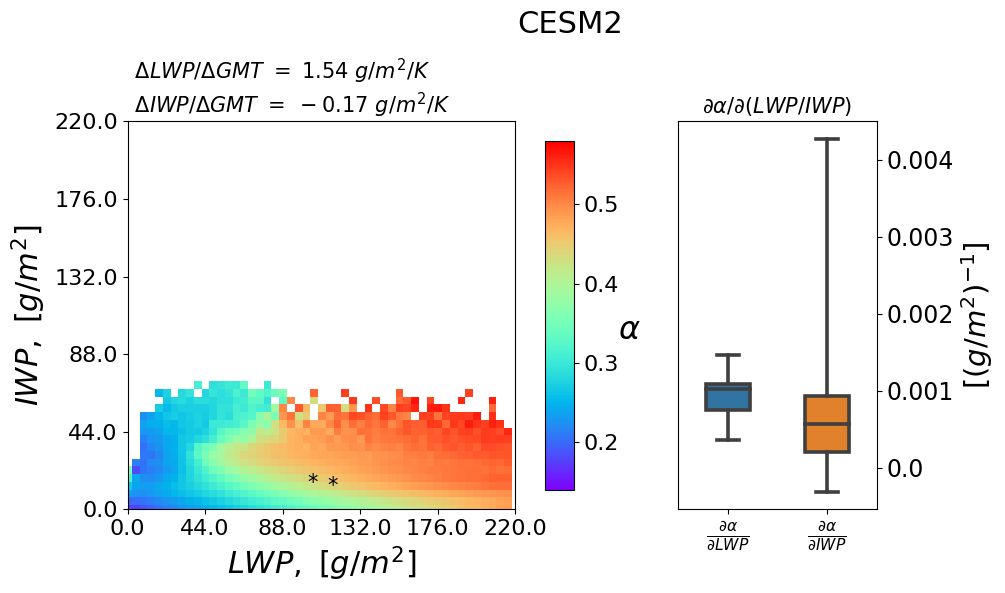

0.001016538385985768 0.0005660062352767974


In [14]:
# Ploting GCM: density plot of albedo versus LWP/IWP + box plot for sensitivities of albedo to LWP and IWP:

from matplotlib import cm
import statsmodels.api as sm
import seaborn as sns
sns.reset_defaults()

# plot settings:
parameters = {'axes.labelsize': 23, 'legend.fontsize': 16,  
       'axes.titlesize': 15, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
plt.rcParams.update(parameters)

fig2, ax21 = plt.subplots(1, 2, figsize = (11.0, 6), gridspec_kw={'width_ratios': [3, 1]}, tight_layout = True)

# print(np.nanmax(lwp_gcm), np.nanmin(lwp_gcm))
# print(np.max(iwp_gcm), np.min(iwp_gcm))
# print(np.max(albedo_gcm), np.min(albedo_gcm))

# Subplot (1):
ax21[0].set_aspect(1)

# binned data by LWP:
BIN_lwp = np.linspace(0., 220., 51)
BIN_iwp = np.linspace(0., 220., 51)

statistic_count, xedge, yedge, binnumber = binned_statistic_2d(1000.* lwp_gcm, 1000.* iwp_gcm, albedo_gcm, 'count', bins=[BIN_lwp, BIN_iwp])
albedo_mean, xedge, yedge, binnumber = binned_statistic_2d(1000.* lwp_gcm, 1000.* iwp_gcm, albedo_gcm, 'mean', bins=[BIN_lwp, BIN_iwp])
ck_albedo_mean, xedge, yedge, binnumber = binned_statistic_2d(1000.* lwp_gcm, 1000.* iwp_gcm, ck_albedo_gcm, 'mean', bins=[BIN_lwp, BIN_iwp])

X_lwp = (BIN_lwp[0:-1] + (BIN_lwp[1] - BIN_lwp[0]) / 2.)
Y_iwp = (BIN_iwp[0:-1] + (BIN_iwp[1] - BIN_iwp[0]) / 2.)

# print(statistic_count, binnumber)
denc2 = ax21[0].imshow(albedo_mean.T, origin = 'lower', cmap = 'rainbow', vmin = 0.14, vmax = 0.46+0.12)
ax21[0].annotate('*', xycoords = 'axes fraction', xy = (LWP_average_pi*1000./220., IWP_average_pi*1000./220.), color = 'black', fontsize = 15, zorder = 99)
ax21[0].annotate('*', xycoords = 'axes fraction', xy = (LWP_average_abr*1000./220., IWP_average_abr*1000./220.), color = 'black', fontsize = 15, zorder = 99)

ax21[0].set_xticks(np.arange(0, len(BIN_lwp), 10))
ax21[0].set_xticklabels(labels= np.round(BIN_lwp[0::10]))
ax21[0].set_yticks(np.arange(0, len(BIN_iwp), 10))
# ax21[0].set_yticklabels(labels = np.round(BIN_alphacs[0::20], 2))
ax21[0].set_yticklabels(labels = np.round(BIN_iwp[0::10]))

ax21[0].set_xlabel("$LWP,\ [g/m^{2}]$", fontsize = 22)
ax21[0].set_ylabel(r"$IWP,\ [g/m^{2}]$", fontsize = 22)
ax21[0].set_xlim(0, 51-1)
ax21[0].set_ylim(0, 51-1)
cb2 = fig2.colorbar(denc2, ax = ax21[0], shrink = 0.90, aspect = 12)
cb2.set_label(r"$\ \alpha$", rotation = 360, fontsize = 23)
plt.minorticks_off()

ax21[0].set_title(r"$\ \Delta LWP/\Delta GMT \ = \ {0} \ g/m^{1}/K\ $" "\n" r"$\ \Delta IWP/\Delta GMT \ = \ {2} \ g/m^{3}/K\ $".format(
    np.round(1000.* delta_LWP_delta_gmt_GCM, 2), 2, np.round(1000.* delta_IWP_delta_gmt_GCM, 2), 2), loc ='left')


# Subplot (2):

n_MAX = 50
coef_LWP = np.zeros((n_MAX))
coef_IWP = np.zeros((n_MAX))
for i in range(n_MAX):
    # Hold IWP be constant bin
    ind_true_x = np.isnan(albedo_mean.T[i, :]) == False
    
    # X = X_lwp[ind_true_x]
    X = np.column_stack((X_lwp[ind_true_x], ck_albedo_mean.T[i, ind_true_x]))  # add clear-sky albedo as a predictor
    Y = albedo_mean.T[i, ind_true_x]
    
    # print(X)
    # print(Y)
    # print(len(X))
    if len(X) > 0:
        X1 = sm.add_constant(X)
        model1 = sm.OLS(Y, X1)
        results_lwp = model1.fit()
        coef_LWP[i] = results_lwp.params[1]
    
    # Hold LWP be constant bin
    ind_true_y = np.isnan(albedo_mean.T[:, i]) == False
    
    # X = Y_iwp[ind_true_y]
    X = np.column_stack((Y_iwp[ind_true_y], ck_albedo_mean.T[ind_true_y, i]))  # add clear-sky albedo as a predictor
    Y = albedo_mean.T[ind_true_y, i]
    
    # print(X)
    # print(Y)
    
    if len(X) > 0:
        X2 = sm.add_constant(X)
        model2 = sm.OLS(Y, X2)
        results_iwp = model2.fit()
        coef_IWP[i] = results_iwp.params[1]

coef_LWP[coef_LWP == 0.0] = np.nan
coef_IWP[coef_IWP == 0.0] = np.nan
print(coef_LWP)
print(coef_IWP)

# Data Frame:
a = np.column_stack((coef_LWP, coef_IWP))
# print(a.shape)
d1 = {'col1': np.arange(0, 50*2), 'value': a.ravel(), 'variable': np.array([r"$ \frac{\partial \alpha}{\partial LWP} $", r"$ \frac{\partial \alpha}{\partial IWP} $"]* 50)}
data1  = pd.DataFrame(data=d1, index=arange(0, 50 * 2))  # radiative sensitivities to LWP and IWP:

# Making Box Plot:
bplot01 = sns.boxplot(ax=ax21[1], x = "variable", y = "value", data = d1, width = 0.45, linewidth = 2.6, whis = 5.0)

ax21[1].yaxis.tick_right()
ax21[1].yaxis.set_label_position("right")
ax21[1].set_title(r"$\partial \alpha/\partial (LWP/IWP) $", fontsize = 15)
ax21[1].set_ylabel(r"$[{(g/m^{2})}^{-1}]$", fontsize = 21)
ax21[1].set_xlabel(bplot01.get_xlabel(), size = 23)
bplot01.set_yticklabels(bplot01.get_yticks(), size = 17)

plt.suptitle(CESM2['modn'], fontsize = 22, x = 0.6)
plt.show()


print(np.nanmedian(coef_LWP), np.nanmedian(coef_IWP))
# plt.savefig(path_plot + "Fig02_CESM2Radiation_sensitivities.jpg", bbox_inches = 'tight', dpi = 500)

In [15]:
savedata_path = '/glade/scratch/chuyan/CMIP_output/CMIP_radiative_sensitivities_RESULT/'

Radiative_sen = {'SWalbedo_LWP':np.nanmedian(coef_LWP), 'SWalbedo_IWP': np.nanmedian(coef_IWP)}
Dclouds_Dgmt = {'DLWP_DGMT': 1000.* delta_LWP_delta_gmt_GCM, 'DIWP_DGMT': 1000.* delta_IWP_delta_gmt_GCM}
np.savez(savedata_path + CESM2['modn'] + '_RSENSITIVITIES' + '_dats', model_data = model_data['modn'], Radiative_sen = Radiative_sen, Dclouds_Dgmt = Dclouds_Dgmt)

print(CESM2['modn'])

CESM2


In [29]:

savedata_path = '/glade/scratch/chuyan/CMIP_output/CMIP_radiative_sensitivities_RESULT/'

# Fio = np.load(savedata_path + CESM2['modn'] + '_RSENSITIVITIES' + '_dats.npz', allow_pickle=True)
# A = Fio['Radiative_sen']
# print(A[()]['SWalbedo_LWP'])
# print(Fio['Dclouds_Dgmt'][()]['DIWP_DGMT'])

# Read radiative sensitivities data:

output_Fio = {}   # storage output file
output_A = {}   # storage the dict 'Radiative_sen'
output_B = {}   # storage the dict 'Dclouds_Dgmt'

output_SWalbedo_LWP = {}
output_SWalbedo_IWP = {}
output_DLWP_DGMT = {}
output_DIWP_DGMT = {}

SWalbedo_LWP_pd = []
SWalbedo_IWP_pd = []
DLWP_DGMT_pd = []
DIWP_DGMT_pd = []


for i in range(len(deck2)):
    # print("i", i)
    
    output_Fio[deck_nas2[i]] = np.load(savedata_path + deck2[i]['modn'] + '_RSENSITIVITIES' + '_dats.npz', allow_pickle=True)
    output_A[deck_nas2[i]] = output_Fio[deck_nas2[i]]['Radiative_sen']
    output_B[deck_nas2[i]] = output_Fio[deck_nas2[i]]['Dclouds_Dgmt']
    
    output_SWalbedo_LWP[deck_nas2[i]] = output_A[deck_nas2[i]][()]['SWalbedo_LWP']
    output_SWalbedo_IWP[deck_nas2[i]] = output_A[deck_nas2[i]][()]['SWalbedo_IWP']
    
    output_DLWP_DGMT[deck_nas2[i]] = output_B[deck_nas2[i]][()]['DLWP_DGMT']
    output_DIWP_DGMT[deck_nas2[i]] = output_B[deck_nas2[i]][()]['DIWP_DGMT']
    
    SWalbedo_LWP_pd.append(output_A[deck_nas2[i]][()]['SWalbedo_LWP'])
    SWalbedo_IWP_pd.append(output_A[deck_nas2[i]][()]['SWalbedo_IWP'])
    
    DLWP_DGMT_pd.append(output_B[deck_nas2[i]][()]['DLWP_DGMT'])
    DIWP_DGMT_pd.append(output_B[deck_nas2[i]][()]['DIWP_DGMT'])
    
print('Down reading Radiative sensitivities Data.')


Down reading Radiative sensitivities Data.


In [105]:
# print(X_lwp[49], Y_iwp[19])
# print(albedo_mean.T[19,49])
# print(statistic_count.T[19,49])

# print(albedo_mean.T[19, :])

ind_true_x = np.isnan(albedo_mean.T[19, :]) == False
X = X_lwp[ind_true_x]
# X = np.column_stack((X_lwp[ind_true_x], ck_albedo_mean.T[19, ind_true_x]))
Y  = albedo_mean.T[19, ind_true_x]
# print(ind_true_x)
# print(X)
# print(Y)

X1 = sm.add_constant(X)
model = sm.OLS(Y, X1)
results = model.fit()
# print(results.summary())
print("Parameters: ", results.params)

# plt.figure()
# plt.scatter(X1[:,1].ravel(), Y, s = 12)
# plt.plot(X1[:,1].ravel(), 0.00536058* X1[:,1].ravel(), 'green')
# plt.plot(X1[:,1].ravel(), 0.0005* X1[:,1].ravel() + 0.4738, 'b')
# plt.plot(X1[:,1].ravel(), 0.0008* X1[:,1].ravel() + 0.7392 *X1[:,2].ravel() + 0.2821, 'r')

Parameters:  [4.73808384e-01 4.61563969e-04]


[0.00138485 0.00143881 0.00137751 0.00135297 0.00130419 0.00119531
 0.00111355 0.00104187 0.0010361  0.00094448 0.00088232 0.0009321
 0.00078749 0.00081259 0.00086487 0.0008941  0.00063673 0.00097129
 0.00093976 0.00083965 0.00054364        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan]
[ 0.00209443  0.0029427   0.00218424  0.00236986  0.00078745  0.00274995
  0.00208974  0.0016137   0.00097453  0.00088558 -0.00011321  0.00141093
  0.00110015  0.00128555  0.00079765  0.00083074  0.00104164  0.00101727
  0.00089192  0.0006482   0.00093176  0.00056951  0.00074117  0.00081228
  0.00101231  0.00092246  0.00107681  0.00103424  0.00115209  0.0010004
  0.00114999  0.00078741  0.0007162   0.00058828  0.00085302  0.00079675
  0.

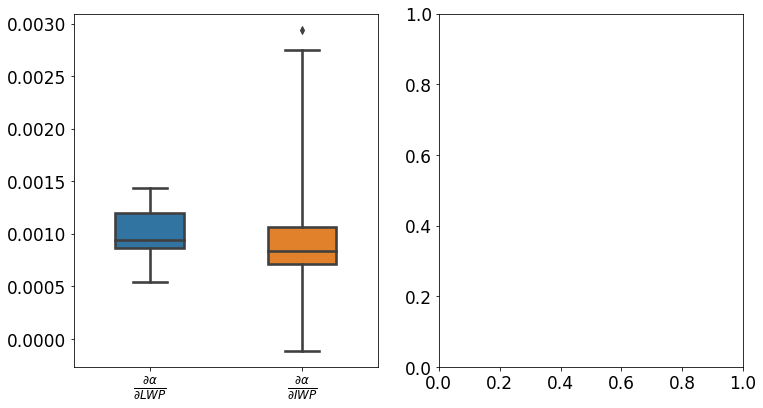

In [141]:
n_MAX = 50
coef_LWP = np.zeros((n_MAX))
coef_IWP = np.zeros((n_MAX))
for i in range(n_MAX):
    # Hold IWP be constant bin
    ind_true_x = np.isnan(albedo_mean.T[i, :]) == False
    
    # X = X_lwp[ind_true_x]
    X = np.column_stack((X_lwp[ind_true_x], ck_albedo_mean.T[i, ind_true_x]))  # add clear-sky albedo as a predictor
    Y = albedo_mean.T[i, ind_true_x]
    
    # print(X)
    # print(Y)
    
    if len(X) > 0:
        X1 = sm.add_constant(X)
        model1 = sm.OLS(Y, X1)
        results_lwp = model1.fit()
        coef_LWP[i] = results_lwp.params[1]
    
    # Hold LWP be constant bin
    ind_true_y = np.isnan(albedo_mean.T[:, i]) == False
    
    # X = Y_iwp[ind_true_y]
    X = np.column_stack((Y_iwp[ind_true_y], ck_albedo_mean.T[ind_true_y, i]))  # add clear-sky albedo as a predictor
    Y = albedo_mean.T[ind_true_y, i]
    
    # print(X)
    # print(Y)
    
    if len(X) > 0:
        X2 = sm.add_constant(X)
        model2 = sm.OLS(Y, X2)
        results_iwp = model2.fit()
        coef_IWP[i] = results_iwp.params[1]

coef_LWP[coef_LWP == 0.0] = np.nan
coef_IWP[coef_IWP == 0.0] = np.nan
print(coef_LWP)
print(coef_IWP)

fig72, ax72 = plt.subplots(1, 2, figsize = (12, 6.5))

parameters = {'axes.labelsize': 23, 'legend.fontsize': 12,
          'axes.titlesize': 14, 'xtick.labelsize': 17, 'ytick.labelsize': 17}
plt.rcParams.update(parameters)
import seaborn as sns
import pandas as pd

# Data Frame:
a = np.column_stack((coef_LWP, coef_IWP))
# print(a.shape)
d1 = {'col1': np.arange(0, 50*2), 'value': a.ravel(), 'variable': np.array([r"$ \frac{\partial \alpha}{\partial LWP} $", r"$ \frac{\partial \alpha}{\partial IWP} $"]* 50)}
data1  = pd.DataFrame(data=d1, index=arange(0, 50 * 2))  # radiative sensitivities to LWP and IWP:

# sns.boxplot(x = coef_LWP, whis = 5.0)
bplot3 = sns.boxplot(ax=ax72[0], x = "variable", y = "value", data = d1, width = 0.45, linewidth = 2.6, whis = 5.0)
# sns.boxplot(x = coef_IWP, whis = 5.0)

In [46]:
import statsmodels.api as sm

nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x ** 2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

X = sm.add_constant(X)
# y = np.dot(X, beta) + e

In [23]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

print("Parameters: ", results.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.773e+06
Date:                Wed, 05 Jul 2023   Prob (F-statistic):          6.78e-247
Time:                        17:57:37   Log-Likelihood:                -128.41
No. Observations:                 100   AIC:                             262.8
Df Residuals:                      97   BIC:                             270.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2739      0.261      4.882      0.0

## Making plots for comparing \Delta LWP/\Delta GMT and \Delta IWP/\Delta GMT and their resulting radiative changes:

In [30]:
print(output_SWalbedo_IWP)
print(output_SWalbedo_IWP_pd)

{'CanESM5': 0.0010044939996255607, 'E3SM10': 0.0011253572645973271, 'CESM2FV2': -0.00030421630610085295, 'CESM2': 0.0005660027478060475, 'CNRMCM61': 0.001728706728421403, 'CESM2WACCMFV2': -0.00029406220422084053, 'CNRMESM21': 0.0020980863751013106, 'NESM3': 0.0003354023720743342, 'IPSLCM6ALR': 0.000607286377229463, 'CESM2WACCM': 0.0005331196776301392, 'MIROCESM': 0.0027124165606196484, 'TaiESM1': 0.0004614456862556183, 'ECEarth3Veg': 0.0008453285338630232, 'CNRMCM61HR': 0.002381465889192895, 'ECEarth3': 0.0009052710353112769, 'FGOALSs2': 0.0019685743901048597, 'IPSLCM5ALR': 0.0013351061127897094, 'CSIRO_Mk360': 0.00023236149010531846, 'BNUESM': -0.000166784874344756, 'GFDLCM3': -0.0001682493936867838, 'GFDLCM4': 0.00011909601237021462, 'SAM0': 0.0008726239599119653, 'CanESM2': 0.00024204876286152734, 'MPIESMLR': 0.0012613282658584276, 'CMCCCM2SR5': 0.0007821933132972879, 'MPIESMMR': 0.0009824058979901794, 'FGOALSg2': -0.0009236173124005133, 'BCCESM1': 0.002989197282067314, 'CNRMCM5': 0

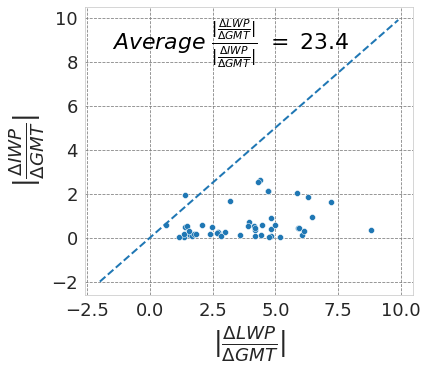

In [121]:
plt.figure(figsize = (10/1.7, 9/1.7))

# plot settings:
parameters = {'axes.labelsize': 26, 'legend.fontsize': 19,  
       'axes.titlesize': 15, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
plt.rcParams.update(parameters)

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})
d2 = {'SWalbedo_LWP': np.array(SWalbedo_LWP_pd), 'SWalbedo_IWP': np.array(SWalbedo_IWP_pd), 'DLWP_DGMT': np.array(DLWP_DGMT_pd), 
       'DIWP_DGMT': np.abs(np.array(DIWP_DGMT_pd))}
data2 = pd.DataFrame(data = d2) # radiative sensitivities to LWP and IWP and the changes in LWP and IWP, scaled by GMT:

# for i in range(len(deck2)):
#     if i == 3:
#         plt.scatter(output_DLWP_DGMT[deck_nas2[i]], output_DIWP_DGMT[deck_nas2[i]], c = 'r', s = 26, marker = 'o')
#     plt.scatter(output_DLWP_DGMT[deck_nas2[i]], output_DIWP_DGMT[deck_nas2[i]], c = 'b', s = 24, marker = 'o')
    
sns.scatterplot(data = data2, x = 'DLWP_DGMT', y = 'DIWP_DGMT')

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})
plt.plot(np.arange(-2., 10., 0.1), np.arange(-2., 10., 0.1), linestyle = '--', linewidth = 2)
plt.annotate(r"$ Average\ \frac{|\frac{\Delta LWP}{\Delta GMT}|}{|\frac{\Delta IWP}{\Delta GMT}|}\ =\ %.1f $"% np.mean(np.array(np.abs(output_DLWP_DGMT_pd))/np.array(np.abs(output_DIWP_DGMT_pd))),
        xy = (-1.5, 8.55), color = 'k', fontsize = 22, zorder = 99)
# plt.xlim(-3, 8)
# plt.ylim(-3, 8)
plt.xlabel(r"$ |\frac{\Delta LWP}{\Delta GMT}| $")
plt.ylabel(r"$ |\frac{\Delta IWP}{\Delta GMT}| $")


plt.savefig(path_plot + "Ratio_of_Change_in_clouds_2.jpg", bbox_inches = 'tight', dpi = 500)

23.44114998511304


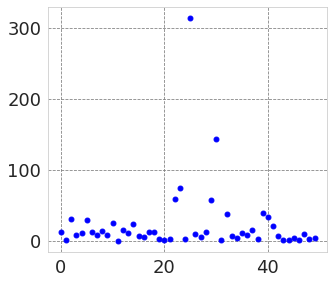

In [101]:
plt.figure(figsize = (10/2, 9/2))
for i in range(len(deck2)):
    plt.scatter(i, np.abs(output_DLWP_DGMT[deck_nas2[i]]/output_DIWP_DGMT[deck_nas2[i]]), c = 'b', s = 24, marker = 'o')
    
print(np.mean(np.array(np.abs(DLWP_DGMT_pd))/np.array(np.abs(DIWP_DGMT_pd))))

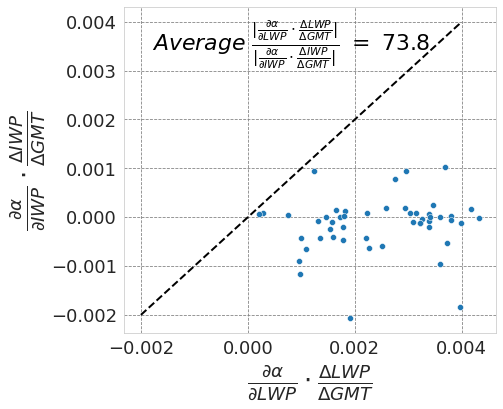

In [120]:
plt.figure(figsize = (10/1.5, 9/1.5))

# plot settings:
parameters = {'axes.labelsize': 26, 'legend.fontsize': 19,  
       'axes.titlesize': 15, 'xtick.labelsize': 18, 'ytick.labelsize': 18}
plt.rcParams.update(parameters)

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})
d3 = {'SWalbedo_LWP_t_DLWP_DGMT': np.array(SWalbedo_LWP_pd) * np.array(DLWP_DGMT_pd), 'SWalbedo_IWP_t_DIWP_DGMT': np.array(SWalbedo_IWP_pd) * np.array(DIWP_DGMT_pd)}
data3 = pd.DataFrame(data = d3) # radiative sensitivities to LWP and IWP and the changes in LWP and IWP, scaled by GMT:

# print(data3)

# for i in range(len(deck2)):
#     if i == 3:
#         plt.scatter(output_DLWP_DGMT[deck_nas2[i]], output_DIWP_DGMT[deck_nas2[i]], c = 'r', s = 26, marker = 'o')
#     plt.scatter(output_DLWP_DGMT[deck_nas2[i]], output_DIWP_DGMT[deck_nas2[i]], c = 'b', s = 24, marker = 'o')
    
sns.scatterplot(data = data3, x = 'SWalbedo_LWP_t_DLWP_DGMT', y = 'SWalbedo_IWP_t_DIWP_DGMT')

sns.set_style("whitegrid", {"grid.color": "gray", "grid.linestyle": "--"})
plt.plot(np.arange(-0.002, 0.005, 0.001), np.arange(-0.002, 0.005, 0.001), c = 'k', linestyle = '--', linewidth = 2)

plt.annotate(r"$ Average\ \frac{|\frac{\partial \alpha}{\partial LWP} \cdot \frac{\Delta LWP}{\Delta GMT}|}{|\frac{\partial \alpha}{\partial IWP} \cdot \frac{\Delta IWP}{\Delta GMT}|}\ =\ %.1f $"% np.nanmean(np.abs(np.array(DLWP_DGMT_pd) * np.array(SWalbedo_LWP_pd))/ np.abs(np.array(DIWP_DGMT_pd) * np.array(SWalbedo_IWP_pd))),
        xy = (-0.0018, 0.0034), color = 'k', fontsize = 22, zorder = 99)
# plt.xlim(-3, 8)
# plt.ylim(-3, 8)
plt.xlabel(r"$ \frac{\partial \alpha}{\partial LWP} \cdot \frac{\Delta LWP}{\Delta GMT} $")
plt.ylabel(r"$ \frac{\partial \alpha}{\partial IWP} \cdot \frac{\Delta IWP}{\Delta GMT} $")


plt.savefig(path_plot + "Ratio_of_Change_in_radiations_2.jpg", bbox_inches = 'tight', dpi = 500)

In [107]:
print((np.abs(np.array(DLWP_DGMT_pd) * np.array(SWalbedo_LWP_pd))/ np.abs(np.array(DIWP_DGMT_pd) * np.array(SWalbedo_IWP_pd))))


[1.65629165e+01 1.68376166e+00 1.29900372e+02 1.62649099e+01
 3.93384889e+00 1.29645980e+02 3.89282699e+00 2.40839603e+01
 1.34825194e+01 1.48359605e+01 1.29665390e+00 1.07196118e+00
 3.37820499e+00 3.56800339e+00 3.39550573e+00 2.15572655e+00
 8.28418598e-01 4.30192400e+01 5.46781476e+01 3.29894021e+01
 1.31498808e+01 3.11797558e+00 1.77053337e+02 3.77880246e+01
 2.34090274e+00 2.33025940e+02 1.07880623e+01 9.21065289e-01
 6.49322733e+00 2.87279290e+01 1.20338528e+02 2.53078354e+01
 1.51592293e+01 1.64362462e+01 8.53540147e+00 5.32317711e+00
 3.57160653e+00 1.11824133e+02 3.29913560e+01 1.76426514e+03
 2.06361502e+01 4.12772145e+02 7.10083890e+00 3.54249108e+00
 3.13468611e+00 5.69112439e+01 2.53078354e+01 4.28867604e+00
 3.42679607e+01 3.72435158e+00]
